In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

### Dataset paid

In [2]:
#dataset = pd.read_csv('../../dataset-processed/pre-processed-01.csv')
dataset_paid = pd.read_csv('../dataset-processed/pre-processed-02-brand-paid.csv')
dataset_paid = dataset_paid.loc[dataset_paid['target'] == 0]
#dataset_paid = dataset_paid.loc[dataset_paid['target'] == 1]
#dataset_paid = dataset_paid.iloc[0:504]
#dataset_paid['target'] = 0
print("Numero di esempi: ", len(dataset_paid))
dataset_paid.head()

Numero di esempi:  485


,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
24,3,1,16,0,0.000024,0.018588,0,1,0,0,0,0,0
25,3,1,95,1,0.000002,0.001370,0,0,0,0,0,0,0
26,3,1,10,0,0.000012,0.004570,0,0,0,0,1,0,0
27,4,1,9,0,0.000010,0.015443,0,0,0,1,0,0,0
28,0,1,18,0,0.000023,0.009499,0,0,0,1,0,0,0


### Dataset standard

In [3]:
#dataset = pd.read_csv('../../dataset-processed/pre-processed-01.csv')
dataset_standard = pd.read_csv('./dataset-processed/pre-processed-01.csv')
print("Numero di esempi standard: ", len(dataset_standard))
dataset_standard.head()

Numero di esempi standard:  504


,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,1,0,0.00000,0.071429,1,0,0,0,0,0,1
1,0,0,1,0,0.00000,0.214286,1,0,0,1,0,0,0
2,0,0,1,1,0.02381,0.142857,1,0,0,1,0,0,0
3,0,0,1,0,0.00000,0.095238,1,0,0,1,0,0,0
4,0,0,1,0,0.02381,0.214286,1,0,0,0,0,1,0


### Merge

In [4]:
dataset = pd.concat([dataset_paid, dataset_standard])
dataset.head()

,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
24,3,1,16,0,0.000024,0.018588,0,1,0,0,0,0,0
25,3,1,95,1,0.000002,0.001370,0,0,0,0,0,0,0
26,3,1,10,0,0.000012,0.004570,0,0,0,0,1,0,0
27,4,1,9,0,0.000010,0.015443,0,0,0,1,0,0,0
28,0,1,18,0,0.000023,0.009499,0,0,0,1,0,0,0


In [5]:
dataset['target'].value_counts()

1    504
0    485
Name: target, dtype: int64

### Feature selection

In [6]:
from sklearn.feature_selection import SelectKBest, chi2

In [7]:
X = dataset.drop(labels=['target'], axis = 1)
y = dataset['target']

In [8]:
X.shape

(989, 12)

In [9]:
X = SelectKBest(chi2, k=7).fit_transform(X, y)

In [10]:
X.shape

(989, 7)

### Z-score

In [11]:
# z-score
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [13]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', sum(y_train == 0))

Esempi training standard:  403
Esempi training paid:  388


In [14]:
print('Esempi training standard: ', sum(y_test == 1))
print('Esempi training paid: ', sum(y_test == 0))

Esempi training standard:  101
Esempi training paid:  97


### Inflate

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
X_train.shape, y_train.shape

((806, 7), (806,))

In [17]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', sum(y_train == 0))

Esempi training standard:  403
Esempi training paid:  403


In [18]:
sm = SMOTE(random_state=2)
X_test, y_test = sm.fit_sample(X_test, y_test.ravel())
X_test.shape, y_test.shape

((202, 7), (202,))

In [19]:
print('Esempi training standard: ', sum(y_test == 1))
print('Esempi training paid: ', sum(y_test == 0))

Esempi training standard:  101
Esempi training paid:  101


### Neural network model

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
print(tf.__version__)

2.1.0


In [21]:
def create_model():
    model = Sequential()
    model.add(Dense(X.shape[1], activation="relu", input_dim = X.shape[1]))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
model = create_model()
epochs = 5
history = model.fit(X_train, y_train, batch_size = 10, epochs = epochs, verbose = 1, validation_data=(X_test, y_test))



Train on 806 samples, validate on 202 samples
Epoch 1/5
806/806 [==============================] - 1s 1ms/sample - loss: 0.2814 - accuracy: 0.9057 - val_loss: 0.1534 - val_accuracy: 0.9554
Epoch 2/5
806/806 [==============================] - 0s 307us/sample - loss: 0.1781 - accuracy: 0.9392 - val_loss: 0.1320 - val_accuracy: 0.9604
Epoch 3/5
806/806 [==============================] - 0s 257us/sample - loss: 0.1679 - accuracy: 0.9392 - val_loss: 0.1126 - val_accuracy: 0.9554
Epoch 4/5
806/806 [==============================] - 0s 259us/sample - loss: 0.1420 - accuracy: 0.9491 - val_loss: 0.0927 - val_accuracy: 0.9653
Epoch 5/5
806/806 [==============================] - 0s 268us/sample - loss: 0.1222 - accuracy: 0.9566 - val_loss: 0.0933 - val_accuracy: 0.9703


In [23]:
model.save('new_model.h5')

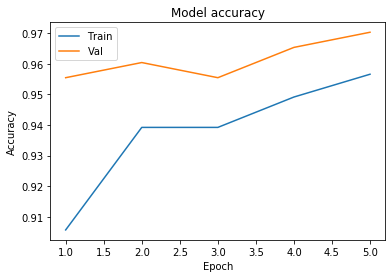

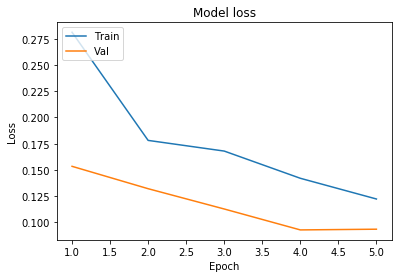

In [24]:
# Plot training & validation accuracy values
epoch_range = range(1, epochs+1)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Evaluate the model

In [25]:
y_pred = model.predict_classes(X_test)
accuracy_score(y_test, y_pred)

0.9702970297029703

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1220aee80>)

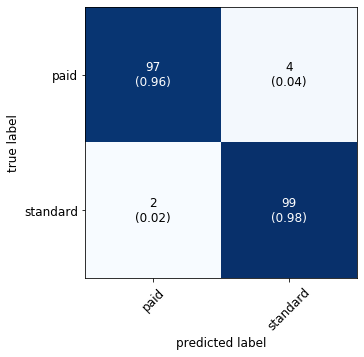

In [26]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       101
           1       0.96      0.98      0.97       101

    accuracy                           0.97       202
   macro avg       0.97      0.97      0.97       202
weighted avg       0.97      0.97      0.97       202



In [28]:
y_pred = model.predict_proba(X_test)

[2.00000000e+00 1.00000000e+00 9.96477187e-01 9.96394455e-01
 9.38626051e-01 9.24595416e-01 9.07944500e-01 9.01746511e-01
 8.58941913e-01 1.01434425e-01 9.80576426e-02 4.43907157e-02
 3.56073752e-02 5.11983817e-04 4.47855564e-04 1.11447895e-04
 9.62703634e-05 8.47406186e-35]


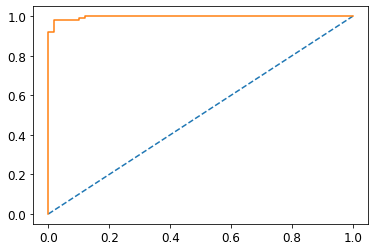

0.9966669934320165


In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#y_pred = y_pred[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(thresholds)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()


# calculate roc auc
auc = roc_auc_score(y_test, y_pred)
print(auc)

In [30]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    #i = np.arange(len(tpr)) 
    #roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    #roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    idx = np.argmax(tpr - fpr)
    print(tpr[idx], fpr[idx])
    return threshold[idx]
    #return list(roc_t['threshold']) 

y_pred = model.predict_proba(X_test)

threshold = find_optimal_cutoff(y_test, y_pred)
print(threshold)

y_pred_new = [1 if x > threshold else 0 for x in y_pred]

0.9801980198019802 0.019801980198019802
0.8589419


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a42944438>)

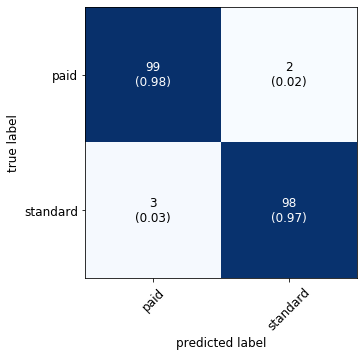

In [31]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred_new)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [32]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       101
           1       0.98      0.97      0.98       101

    accuracy                           0.98       202
   macro avg       0.98      0.98      0.98       202
weighted avg       0.98      0.98      0.98       202



### Logistic Regression Model

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
classifier = LogisticRegression(class_weight={0: 1, 1: 1})
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9801980198019802


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4289b0f0>)

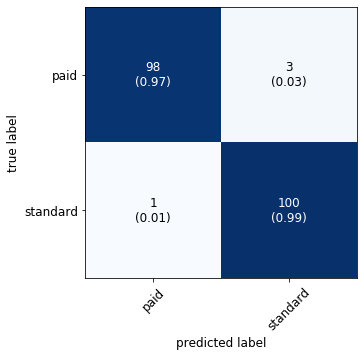

In [35]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       101
           1       0.97      0.99      0.98       101

    accuracy                           0.98       202
   macro avg       0.98      0.98      0.98       202
weighted avg       0.98      0.98      0.98       202



### SVM Model

In [37]:
from sklearn.svm import SVC

In [38]:
classifier = SVC(class_weight={0: 1, 1: 1})
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9801980198019802


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a42b4ca90>)

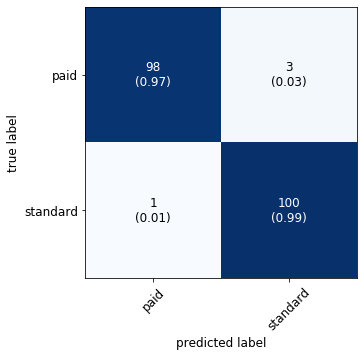

In [39]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       101
           1       0.97      0.99      0.98       101

    accuracy                           0.98       202
   macro avg       0.98      0.98      0.98       202
weighted avg       0.98      0.98      0.98       202



### Random Forest Model

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
# max_features=3
classifier = RandomForestClassifier(max_depth=2, max_leaf_nodes=3)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9801980198019802


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a42ba57b8>)

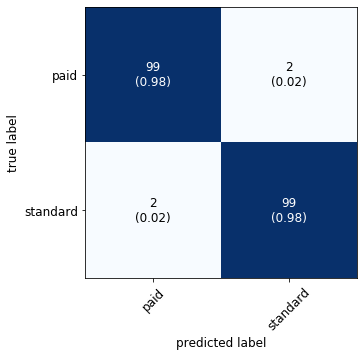

In [43]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       101
           1       0.98      0.98      0.98       101

    accuracy                           0.98       202
   macro avg       0.98      0.98      0.98       202
weighted avg       0.98      0.98      0.98       202

